# Segmentación mediante KNN

El siguiente código presenta un ejemplo de como realizar la segmentación de imagenes implementado con scikit-image (skimage) y la técnica KNN de sklearn. Este modelo se basa en **clasificar pixeles**, por lo que los datos de entrada serán representaciones de pixeles y las etiquetas corresponden a las clases.

Utiliza imágenes de la base de datos ISIC sobre cáncer de piel con sus respectivas máscaras.

Nota: La ejecución puede tardar un tiempo considerable dependiendo del tamaño de la imagen, principalmente al usar extracción de características.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, segmentation, feature, future
from sklearn.neighbors import KNeighborsClassifier
from functools import partial
from PIL import Image

**Imagen de muestra**

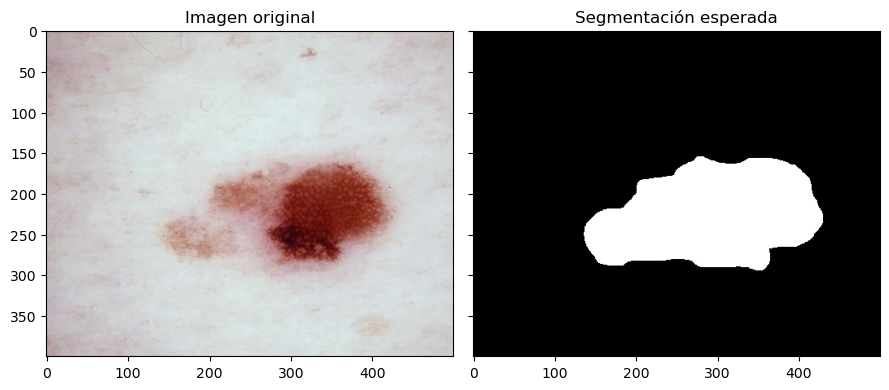

In [2]:
full_img = plt.imread("ISIC_0024313.jpg")
image = Image.open('ISIC_0024313_segmentation.jpg').convert("L")
segmented = np.asarray(image)

segm = segmented[:400, :500]
img = full_img[:400, :500]

fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(9, 4))
ax[0].imshow(img)
ax[0].set_title("Imagen original")
ax[1].imshow(segm, cmap='gray')
ax[1].set_title("Segmentación esperada")
fig.tight_layout()

Se asigna un valor por clase mediante regiones delimitadoras (cuadrados) para etiquetar pixeles de forma que signifique región de interés (posible melanoma) o piel. {1,2} respectivamente

In [3]:
training_labels = np.zeros(img.shape[:2], dtype=np.uint8)
training_labels[0:150 ,0:150] = 1
training_labels[200:250, 250:300] = 2

## Utilizando solo la imagen de prueba

Se instancia un clasificador KNN (con sklearn) y 3 vecinos de hiperparámetro

In [4]:
clf = KNeighborsClassifier(n_neighbors=3)

Entrena con los valores de intensidad de las etiquetas antes asignadas en las regiones de la imagen

In [5]:
clf = future.fit_segmenter(training_labels, img, clf)

Se pedice la etiqueta para todos los pixeles de la imagen. Es decir, para los pixeles de entrenamiento y los de prueba (los que se incluyen en las regiones y los que no)

In [6]:
result = future.predict_segmenter(img, clf)

Se muestran los resultados

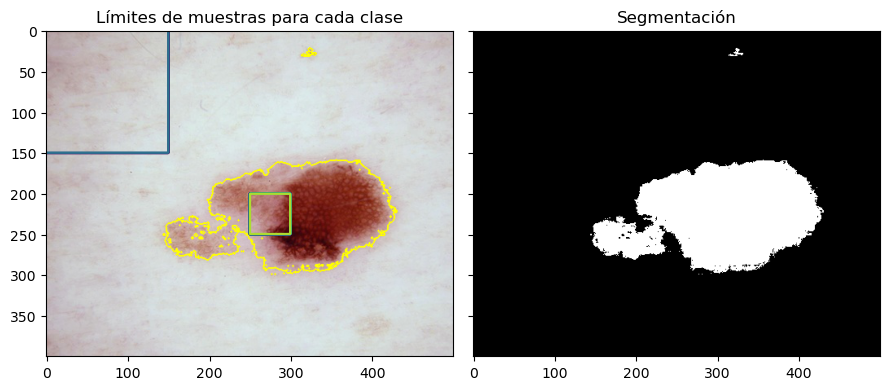

In [7]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(9, 4))
ax[0].imshow(segmentation.mark_boundaries(img, result, mode='thick'))
ax[0].contour(training_labels)
ax[0].set_title('Límites de muestras para cada clase')
ax[1].imshow(result, cmap='gray')
ax[1].set_title('Segmentación')
fig.tight_layout()

Se calcula métrica Intersección sobre Unión (IoU) o Índice de Jaccard contra la máscara de segmentación esperada para saber qué porcentaje de la segmentación es correcta

In [8]:
def calculaIoU(gtMask, predMask):
        # Calcula verdaderos positivos, falsos positivos, and falsos negativos
        tp = 0
        fp = 0
        fn = 0
        for i in range(len(gtMask)):
            for j in range(len(gtMask[0])):
                if gtMask[i][j] == 1 and predMask[i][j] == 2:
                    tp += 1
                elif gtMask[i][j] == 0 and predMask[i][j] == 2:
                    fp += 1
                elif gtMask[i][j] == 1 and predMask[i][j] == 1:
                    fn += 1

        # Calcula IoU
        iou = tp / (tp + fp + fn)

        return iou

In [9]:
print("El porcentaje de segmentación correcta es: {}%".format(round(1-calculaIoU(segm, result),4)*100))

El porcentaje de segmentación correcta es: 92.13%


## Utilizando extracción de características

El siguiente código sirve para aplicar un banco de filtros y transformaciones a la imagen para extraer características de la región de interés manejadas en forma de vector.

In [10]:
sigma_min = 1
sigma_max = 16
features_func = partial(feature.multiscale_basic_features,
                        intensity=True, edges=False, texture=True,
                        sigma_min=sigma_min, sigma_max=sigma_max,
                        channel_axis=-1)
features = features_func(img)

Se define un clasificador KNN

In [11]:
clf_ec = KNeighborsClassifier(n_neighbors=3)

Entrena con las etiquetas de la mascara antes realizada y las caracteristicas

In [12]:
clf_ec = future.fit_segmenter(training_labels, features, clf_ec)

Se pedice la etiqueta para todos los pixeles de la imagen (es decir, para los pixeles de entrenamiento y los de prueba)

In [13]:
result = future.predict_segmenter(features, clf_ec)

Se muestran los resultados

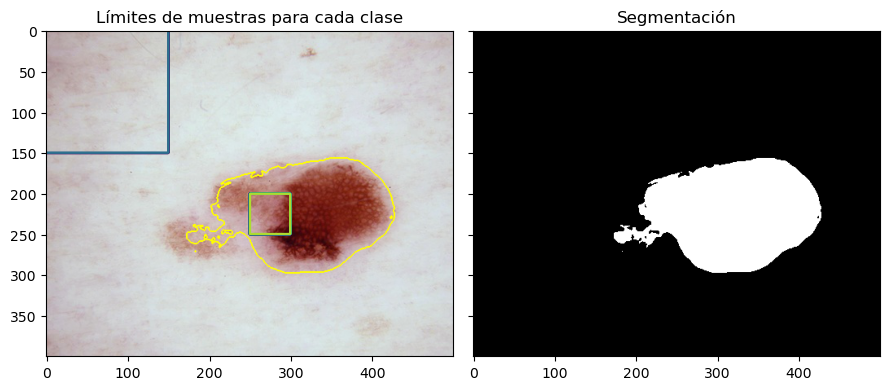

In [14]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(9, 4))
ax[0].imshow(segmentation.mark_boundaries(img, result, mode='thick'))
ax[0].contour(training_labels)
ax[0].set_title('Límites de muestras para cada clase')
ax[1].imshow(result, cmap='gray')
ax[1].set_title('Segmentación')
fig.tight_layout()

In [15]:
print("El porcentaje de segmentación correcta es: {}%".format(round(1-calculaIoU(segm, result),4)*100))

El porcentaje de segmentación correcta es: 90.42999999999999%


# Ejercicio. Divida todos los datos proporcionados (imágenes de melanoma) en conjuntos de entrenamiento y prueba. Replique el ejercicio de muestra con esos datos, es decir, implemente un clasificador KNN utilizando todas las imágenes en conjunto, recordando que la clasificación es por pixel. Pruebe diferentes valores para el hiperparamétro, explore la función para extraer características y varíe las coordenadas y tamaños de cuadros delimitadores para alguna imagen individual.

In [21]:
import os
from sklearn.model_selection import train_test_split

# List of images and sementations
image_files = [f for f in os.listdir() if f.endswith(".jpg") and "segmentation" not in f]
mask_files = [f for f in os.listdir() if f.endswith("segmentation.jpg")]

# Order the lists
image_files.sort()
mask_files.sort()

# Test train split 80/20
train_imgs, test_imgs, train_masks, test_masks = train_test_split(image_files, mask_files, test_size=0.2, random_state=42)

print("Imágenes de entrenamiento:", train_imgs)
print("Imágenes de prueba:", test_imgs)


Imágenes de entrenamiento: ['ISIC_0024496.jpg', 'ISIC_0024313.jpg', 'ISIC_0024481.jpg']
Imágenes de prueba: ['ISIC_0024351.jpg']


In [23]:
def load_image_and_mask(image_path, mask_path):
    image = plt.imread(image_path)
    mask = Image.open(mask_path).convert("L")
    return image, np.asarray(mask)

# create variables to store training data
X_train = []
Y_train = []

for img_path, mask_path in zip(train_imgs, train_masks):
    img, segm = load_image_and_mask(img_path, mask_path)
    
    #Region selection we select the center as melanoma as melomas are centered in all images 
    training_labels = np.zeros(img.shape[:2], dtype=np.uint8)
    training_labels[0:150, 0:150] = 1  # skin
    training_labels[200:250, 250:300] = 2  # melanoma
    
    # Compute features -> 
    features = feature.multiscale_basic_features(img, sigma_min=1, sigma_max=16, num_sigma=5)
    
    # Adding data to list
    mask_pixels = training_labels > 0

    # Reshape X_selected to ensure it is 2D (samples, features)
    X_selected = features[mask_pixels].reshape(mask_pixels.sum(), -1)
    Y_selected = training_labels[mask_pixels]

    # Ensure consistency in shape
    assert X_selected.shape[0] == Y_selected.shape[0], f"Mismatch: {X_selected.shape[0]} vs {Y_selected.shape[0]}"

    X_train.append(X_selected)
    Y_train.append(Y_selected)

# Connecting the data of all images
X_train = np.concatenate(X_train, axis=0)  # Shape should now be (num_samples, num_features)
Y_train = np.concatenate(Y_train, axis=0)  # Shape (num_samples,)

# Verifying shape
print(f"Final X_train shape: {X_train.shape}")  
print(f"Final Y_train shape: {Y_train.shape}")

# training on k = 5
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(X_train, Y_train)

print("Clasificador kNN entrenado con múltiples imágenes.")


Final X_train shape: (75000, 75)
Final Y_train shape: (75000,)
Clasificador kNN entrenado con múltiples imágenes.


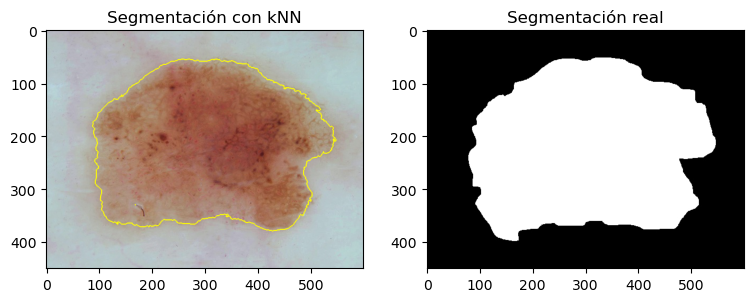

In [26]:
for img_path, mask_path in zip(test_imgs, test_masks):
    img, segm = load_image_and_mask(img_path, mask_path)
    
    # Extract features for the test image
    test_features = feature.multiscale_basic_features(img, sigma_min=1, sigma_max=16, num_sigma=5)
    test_shape = test_features.shape[:2]
    
    # Ensure test features match training features
    num_features_train = X_train.shape[1]  
    test_features = test_features.reshape(-1, num_features_train)

    # predict with trained knn
    result = knn_classifier.predict(test_features).reshape(test_shape)
    
    # Visualizamos la segmentación obtenida
    fig, ax = plt.subplots(1, 2, figsize=(9, 4))
    ax[0].imshow(segmentation.mark_boundaries(img, result, mode='thick'))
    ax[0].set_title("Segmentación con kNN")
    ax[1].imshow(segm, cmap='gray')
    ax[1].set_title("Segmentación real")
    plt.show()


k=1, IoU=0.9284
k=3, IoU=0.9293
k=5, IoU=0.9293
k=7, IoU=0.9297
k=9, IoU=0.9308
k=11, IoU=0.9324


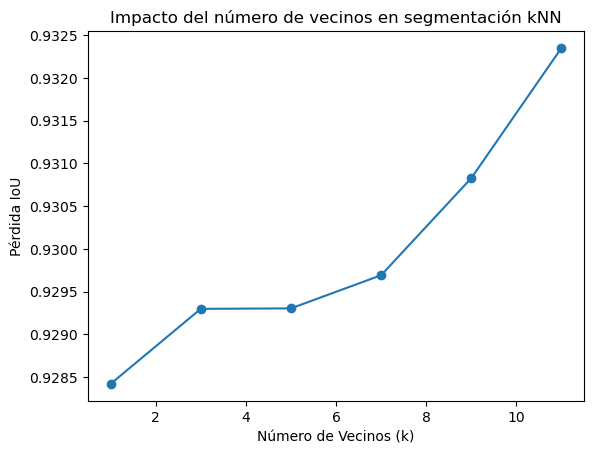

In [ ]:
k_values = [1, 3, 5, 7, 9, 11]
iou_scores = []

for k in k_values:
    knn_classifier = KNeighborsClassifier(n_neighbors=k)
    knn_classifier.fit(X_train, Y_train)
    
    img, segm = load_image_and_mask(test_imgs[0], test_masks[0])
    test_features = feature.multiscale_basic_features(img, sigma_min=1, sigma_max=16, num_sigma=5)
    test_shape = test_features.shape[:2]
    
    # Ensure test features match training features
    test_features = test_features.reshape(-1, X_train.shape[1])  

    result = knn_classifier.predict(test_features).reshape(test_shape)
    
    iou = 1 - calculaIoU(segm, result) 
    iou_scores.append(iou)
    
    print(f"k={k}, IoU={iou:.4f}")

plt.plot(k_values, iou_scores, marker='o')
plt.xlabel("Número de Vecinos (k)")
plt.ylabel("Pérdida IoU")
plt.title("Impacto del número de vecinos en segmentación kNN")
plt.show()


Optimized kNN classifier trained.


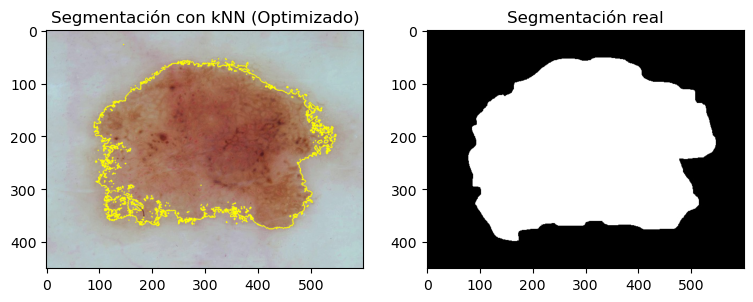

In [29]:
# Function to extract features from selected pixels
def extract_features(image, labels, sample_size=5000):
    """
    Extracts intensity-based features from a limited number of pixels.
    This speeds up training while maintaining efficiency.
    """
    # Convert image to grayscale
    if len(image.shape) == 3:
        image_gray = np.mean(image, axis=-1)
    else:
        image_gray = image

    # Get pixel positions of labeled regions
    mask_pixels = np.where(labels > 0)
    
    # Randomly sample a subset of pixels
    if len(mask_pixels[0]) > sample_size:
        indices = np.random.choice(len(mask_pixels[0]), sample_size, replace=False)
        sampled_pixels = (mask_pixels[0][indices], mask_pixels[1][indices])
    else:
        sampled_pixels = mask_pixels
    
    # Extract features (using intensity values)
    X_features = image_gray[sampled_pixels]
    Y_labels = labels[sampled_pixels]
    
    return X_features.reshape(-1, 1), Y_labels  # Reshape to 1D feature array

X_train = []
Y_train = []

for img_path, mask_path in zip(train_imgs, train_masks):
    img, segm = load_image_and_mask(img_path, mask_path)
    
    # Define labeled regions (adjust as needed)
    training_labels = np.zeros(img.shape[:2], dtype=np.uint8)
    training_labels[0:150, 0:150] = 1  # Melanoma region
    training_labels[200:250, 250:300] = 2  # Skin region
    
    # Extract features (SAMPLE pixels for speed)
    features, labels = extract_features(img, training_labels, sample_size=3000)
    X_train.append(features)
    Y_train.append(labels)

# Convert to numpy arrays
X_train = np.vstack(X_train)
Y_train = np.hstack(Y_train)

# Train kNN classifier (FAST version)
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(X_train, Y_train)

print("Optimized kNN classifier trained.")

# Testing phase
for img_path, mask_path in zip(test_imgs, test_masks):
    img, segm = load_image_and_mask(img_path, mask_path)
    
    # Extract intensity features for ALL pixels
    img_gray = np.mean(img, axis=-1).reshape(-1, 1)
    
    # Predict using kNN
    result = knn_classifier.predict(img_gray).reshape(img.shape[:2])

    # Visualize results
    fig, ax = plt.subplots(1, 2, figsize=(9, 4))
    ax[0].imshow(segmentation.mark_boundaries(img, result, mode='thick'))
    ax[0].set_title("Segmentation con kNN sin multiscale features")
    ax[1].imshow(segm, cmap='gray')
    ax[1].set_title("Segmentación real")
    plt.show()